In [21]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import Lambda

data --> x and y
stratify = y # Stratify the data based on the target variable

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 42 , stratify = y)

xtrain, ytrain --> train_dataframe --> ultrasound dataset dataframe

In [22]:
# def preprocess_image(image_path):
#     # define the transformations
#     preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ])
#     # load the image
#     input_image = Image.open(image_path)

#     # preprocess the image
#     input_tensor = preprocess(input_image)

#     # image size is 3x224x224 add the batch size
#     input_batch = input_tensor.unsqueeze(0)
    
#     return input_batch

In [23]:
class UltrasoundDataset(Dataset):
    '''
    Custom dataset class for ultrasound images
    '''
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        return image, label

In [24]:
# Define the preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #grayscale to RGB since the model was trained on RGB images
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) are values of mean and std of ImageNet dataset
# because the model was trained on ImageNet dataset

# Load the dataframe
df = pd.read_csv('dataset.csv')
#replace backslashes with forward slashes
df['image_path'] = df['image_path'].str.replace('\\', '/')

# # split the data into train and validation
# train_df = df.sample(frac=0.8, random_state=42)
# val_df = df.drop(train_df.index)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['true_label_num'], random_state=42)

# Create the Dataset
train_dataset = UltrasoundDataset(dataframe=train_df, transform=preprocess)
val_dataset = UltrasoundDataset(dataframe=val_df, transform=preprocess)

# Create the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

In [25]:
#print train and validation dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Train dataset size: 624
Validation dataset size: 157


In [26]:
#distribution of classes in the dataset
print("Train dataset class distribution")
print(train_df['true_label_num'].value_counts(normalize=True))
print("Validation dataset class distribution")
print(val_df['true_label_num'].value_counts(normalize=True))
#show the distribution of classes in the dataset
#original class labels values count
print("Original class labels values count")
print(df['true_label_num'].value_counts(normalize=True))



Train dataset class distribution
true_label_num
1    0.560897
2    0.269231
0    0.169872
Name: proportion, dtype: float64
Validation dataset class distribution
true_label_num
1    0.560510
2    0.267516
0    0.171975
Name: proportion, dtype: float64
Original class labels values count
true_label_num
1    0.560819
2    0.268886
0    0.170294
Name: proportion, dtype: float64


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained vgg 16 model
vgg16 = models.vgg16(weights='DEFAULT')
print(vgg16)
# replace the last layer with a new layer with 3 output features
vgg16.classifier[6] = torch.nn.Linear(4096, 3)
print(vgg16)


#freeze all layers except the last one
for param in vgg16.parameters():
    param.requires_grad = False
    
for param in vgg16.classifier.parameters():
    param.requires_grad = True
    
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()
#use strict mode for the criterion
#high weighted loss when error in benign and malignant classes
#weight the loss for benign and malignant classes
#high weight for benign and malignant classes
# weights = torch.tensor([1.0, 5.0, 7.0])
# weights = weights.to(device)
# criterion = torch.nn.CrossEntropyLoss(weight=weights)


# use very small learning rate for all layers except the last layer
# use adam optimizer
optimizer = torch.optim.Adam([
    {'params': vgg16.features.parameters(), 'lr': 1e-4},
    {'params': vgg16.classifier.parameters(), 'lr': 1e-3}
])

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
#list files in current directory
print(os.listdir())

['SAM_predictions_box_point', 'vgg16_finetune.ipynb', 'breastSAM.ipynb', '1.png', 'rushi.ipynb', 'sam_vit_l_0b3195.pth', 'benign_without_points.csv', 'malignant_with_points.csv', 'Dataset_BUSI_with_GT', 'SAM_predictions', 'benign_with_points.csv', 'malignant_without_points.csv', 'dataset.csv', 'tests.ipynb', 'rushi-Vivek.ipynb', 'vgg16_tuned.pth', '307 - Segment your images in python without training.py', 'how_to_segment_anything_with_sam.ipynb', 'data']


In [42]:
#list all files in dataset_BUSI_with_GT folder
files = os.listdir('Dataset_BUSI_with_GT')
print(files)

['malignant', 'benign_bounding_box.csv', 'benign', 'generateprompt.ipynb', 'normal', 'malignant_bounding_box.csv']


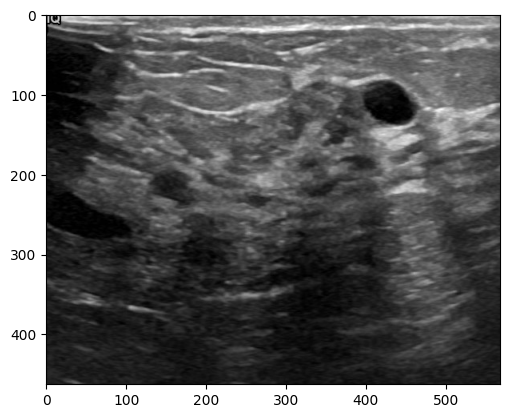

In [43]:
image_path='Dataset_BUSI_with_GT/benign/benign (161).png'

#show the image
img = Image.open(image_path)
plt.imshow(img)
plt.show()


In [44]:
# Train the model
num_epochs = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)
vgg16.train()

with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for i, (images, labels) in enumerate(train_dataloader):
            
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = vgg16(images)

            # calculate the loss
            loss = criterion(outputs, labels)

            # zero the gradients
            optimizer.zero_grad()

            # backward pass
            loss.backward()

            # update the weights
            optimizer.step()

            t.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

        # Evaluate the model
        vgg16.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = vgg16(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Accuracy: {accuracy:.4f}')
        t.set_postfix(accuracy=accuracy)
        vgg16.train()



Epoch 2/8, Loss: 2.1300:  12%|█▎        | 1/8 [00:09<01:07,  9.64s/it, accuracy=0.745]

Accuracy: 0.7452


Epoch 3/8, Loss: 0.0000:  25%|██▌       | 2/8 [00:19<00:58,  9.71s/it, accuracy=0.79]  

Accuracy: 0.7898


Epoch 4/8, Loss: 0.0000:  38%|███▊      | 3/8 [00:29<00:49,  9.84s/it, accuracy=0.752]

Accuracy: 0.7516


Epoch 5/8, Loss: 0.0000:  50%|█████     | 4/8 [00:39<00:39,  9.84s/it, accuracy=0.65]  

Accuracy: 0.6497


Epoch 6/8, Loss: 1.7288:  62%|██████▎   | 5/8 [00:49<00:29,  9.84s/it, accuracy=0.79] 

Accuracy: 0.7898


Epoch 7/8, Loss: 0.0147:  75%|███████▌  | 6/8 [00:59<00:19,  9.97s/it, accuracy=0.726]

Accuracy: 0.7261


Epoch 8/8, Loss: 0.0000:  88%|████████▊ | 7/8 [01:09<00:09,  9.99s/it, accuracy=0.815] 

Accuracy: 0.8153


Epoch 8/8, Loss: 4.5799: 100%|██████████| 8/8 [01:19<00:00,  9.92s/it, accuracy=0.809] 

Accuracy: 0.8089


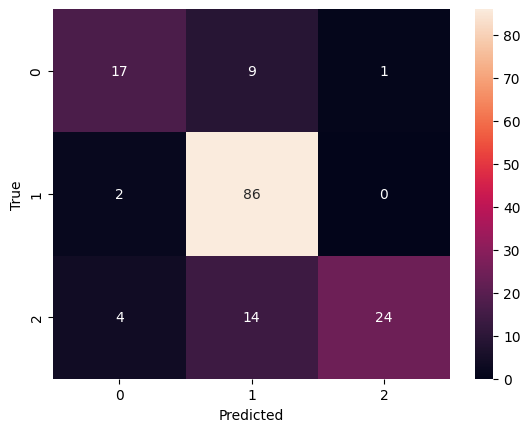

In [45]:
#plot confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns

vgg16.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        #PREPROCESS THE IMAGES
        
        

        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [53]:
#evaluate f1 score,presicion,recall

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.74      0.63      0.68        27
           1       0.79      0.98      0.87        88
           2       0.96      0.57      0.72        42

    accuracy                           0.81       157
   macro avg       0.83      0.73      0.76       157
weighted avg       0.83      0.81      0.80       157



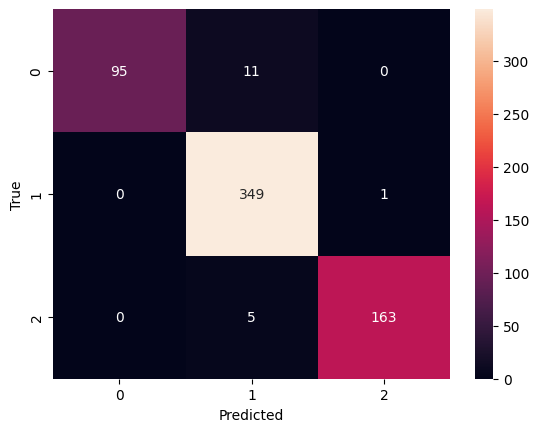

In [33]:
vgg16.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        #PREPROCESS THE IMAGES
        
        

        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [34]:
# Save the model

torch.save(vgg16.state_dict(), 'vgg16_tuned.pth')


In [35]:
# #generate class activation map

# # Load the model
# vgg16 = models.vgg16(weights='DEFAULT')
# vgg16.classifier[6] = torch.nn.Linear(4096, 3)
# vgg16.load_state_dict(torch.load('vgg16_tuned.pth'))

# # Get the weights of the last layer
# weights = vgg16.classifier[6].weight.data

# # Get the features of the last convolutional layer
# features = vgg16.features

# # Get the image
# image_path = 'Dataset_BUSI_with_GT/benign/benign (161).png'

# # Preprocess the image
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# image = Image.open(image_path)

# # Get the features of the image
# image_tensor = preprocess(image).unsqueeze(0)

# # Get the features of the image
# features = vgg16.features(image_tensor)

# # Get the output of the model
# output = vgg16(image_tensor)

# # Get the class index
# _, predicted = torch.max(output, 1)

# # Get the weights of the predicted class
# weights = weights[predicted]

# # Get the class activation map
# cam = torch.matmul(weights, features.view(features.size(0), -1))

# # Normalize the class activation map
# cam = torch.nn.functional.relu(cam)
# cam = cam.view(cam.size(0), 14, 14)
# cam = cam - cam.min()
# cam = cam / cam.max()

# # Plot the class activation map
# plt.imshow(cam.squeeze().detach().numpy())
# plt.show()


In [36]:
# !pip install torchcam

In [37]:
#print all types of models available in torchcam
#from torchcam.methods import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM, SSCAM, ISSCAM, XGradCAM, LayerCAM, EigenCAM, EigenGradCAM, LayerGradCAM, LayerScoreCAM, LayerSSCAM, LayerISSCAM, LayerXGradCAM
import torchcam
print(dir(torchcam.methods))

['CAM', 'GradCAM', 'GradCAMpp', 'ISCAM', 'LayerCAM', 'SSCAM', 'ScoreCAM', 'SmoothGradCAMpp', 'XGradCAM', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'activation', 'core', 'gradient']


In [38]:
#install eigen cam
#site for eigen cam is  

In [46]:
from torchcam.methods import ScoreCAM as GM

# Load the model
vgg16 = models.vgg16(weights='DEFAULT')
vgg16.classifier[6] = torch.nn.Linear(4096, 3)
vgg16.load_state_dict(torch.load('vgg16_tuned.pth'))

# Get the class activation map
cam = GM(model=vgg16, target_layer='features.29')

# Get the image
image_path = 'Dataset_BUSI_with_GT/benign/benign (1).png'

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open(image_path)
image_tensor = preprocess(image).unsqueeze(0)

# Get the class activation map
#forward pass the image through the model
#use classid 0 for benign class
#forward pass the image through the model
#use classid 0 for benign class

#forward
with torch.no_grad():
    output = vgg16(image_tensor)
    print(output)
    activation_map = cam(class_idx=0)
    

# Plot the class activation map



tensor([[-102.8975,  109.5834,  -67.2784]])


In [47]:
#print len of activation_map
print(len(activation_map))

1


In [52]:
print(activation_map[0])

tensor([[[4.2670e-05, 1.6776e-04, 2.0271e-04, 2.3378e-04, 2.7495e-04,
          5.4260e-04, 1.0482e-03, 1.4025e-03, 1.1667e-03, 6.0553e-04,
          5.6752e-04, 4.2716e-04, 2.2688e-04, 2.1251e-04],
         [1.6285e-04, 3.0401e-04, 1.4843e-04, 0.0000e+00, 1.6285e-04,
          7.6508e-04, 1.2538e-03, 1.0918e-03, 9.3427e-04, 6.8175e-04,
          5.4699e-05, 1.8734e-05, 1.1333e-06, 1.7708e-04],
         [6.1188e-04, 7.3629e-04, 7.4739e-04, 3.2623e-04, 7.5821e-04,
          1.6584e-03, 1.4306e-03, 1.7036e-03, 3.9980e-03, 1.7996e-03,
          1.0949e-03, 2.9888e-04, 3.2778e-05, 3.3791e-04],
         [7.8887e-04, 9.9412e-04, 9.0033e-04, 6.0149e-04, 1.7834e-03,
          2.8337e-03, 2.1885e-03, 1.3556e-02, 1.3659e-02, 1.0719e-02,
          2.8363e-03, 2.0723e-03, 1.1890e-03, 1.1647e-03],
         [7.3690e-04, 8.9134e-04, 6.4788e-04, 6.9262e-04, 2.1116e-03,
          3.9857e-03, 8.1910e-03, 2.2641e-02, 2.6358e-02, 2.1760e-02,
          8.6339e-03, 2.3905e-03, 2.4496e-03, 2.3710e-03],
     

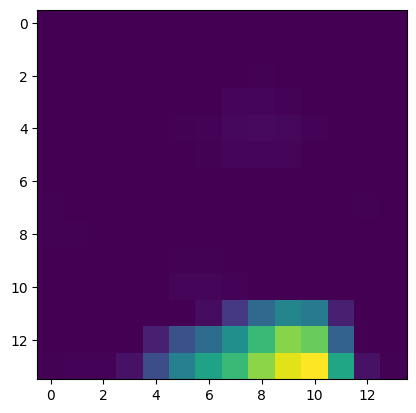

In [48]:
plt.imshow(activation_map[0].squeeze().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


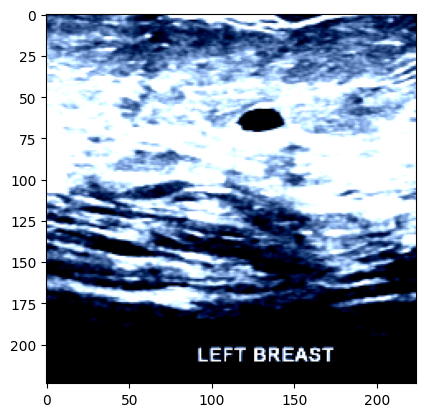

In [49]:
#plot original image
#plot image_tensor
plt.imshow(image_tensor.squeeze().permute(1, 2, 0).numpy())
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


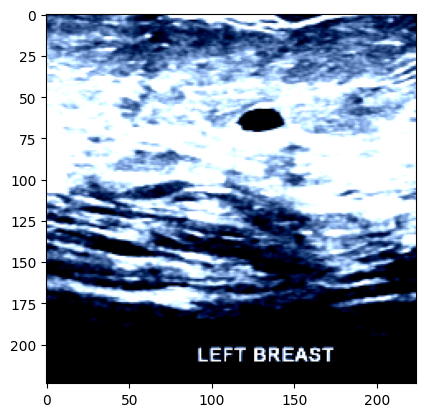

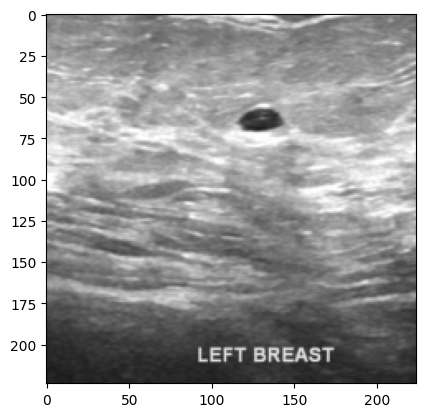

In [50]:
image_path = 'Dataset_BUSI_with_GT/benign/benign (1).png'

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = Image.open(image_path)

#
image_tensor = preprocess(image).unsqueeze(0)

#show the image_tensor as image
plt.imshow(image_tensor.squeeze().permute(1, 2, 0).detach().numpy())
plt.show()


#color image in better way

preprocess = transforms.Compose([
    
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #use lambda function to convert grayscale to RGB image should the image be grayscale
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

image = Image.open(image_path)
image_tensor = preprocess(image).unsqueeze(0)

#show the image_tensor as image
plt.imshow(image_tensor.squeeze().permute(1, 2, 0).detach().numpy())
